# IDEA: We may NOT need much datapoints for training a QCNN

In [1]:
""" This module implements the base function to implement a VQE for a Ising Chain with Transverse Field. """
from pennylane import numpy as np

import sys, os
sys.path.insert(0, '../')
import vqe as vqe
import annni_model as annni
import qcnn as qcnn
import visualization as qplt
import losses
import general as qmlgen
import encoder as enc

import joblib
from matplotlib import pyplot as plt

In [52]:
def low_points_random(vqeclass, lr, epochs, n_qcnns, S_sizes, sigma = 45, plot = True, gaussian = True):
    if plot and gaussian:
        def gaussian(x, mu, sig):
            return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))
        mu = int(np.sqrt(vqeclass.n_states))//2
        x = np.arange(mu-3*sigma,mu+3*sigma)
        plt.plot(x, gaussian(x, mu, sigma) )
        plt.axvline(x=0, ls = '--', color='red')
        plt.axvline(x=2*mu, ls = '--', color='red')
        plt.title('Drawing distribution')
        plt.show()
                 
    mean_acc = []
    std_acc  = []

    for S_size in S_sizes:
        accs = []

        for _ in range(n_qcnns):
            if gaussian:
                train_index = qcnn.get_trainset_gaussian(vqeclass, S_size, sigma = sigma)
            else:
                train_index_x = np.random.choice(np.arange(side), size=S_size//2, replace = False)
                train_index_y = np.random.choice(np.arange(side, 2*side-1), size=S_size//2, replace = False)
                
                train_index = np.concatenate((train_index_x, train_index_y))
                                                 
            qcnnclass = qcnn.qcnn(vqeclass, qcnn.qcnn_circuit, n_outputs = 2)
            qcnnclass.train(lr, epochs, train_index, losses.cross_entropy)

            accs.append(qcnn.ANNNI_accuracy(qcnnclass, plot = False) )

        mean_acc.append(np.mean(accs))
        std_acc.append(np.std(accs))

    s_str = ''
    for s_size in S_sizes:
        s_str += str(s_size) + '_'

    path      = '../data/'
    folder    = 'N'+str(N)+'n'+str(side)+'sizes'+s_str[:-1]
    subfolder = 'gaussian' if gaussian else 'uniform'

    if folder not in os.listdir(path):
        os.makedirs(path+folder)
    if subfolder not in os.listdir(path+folder):
        os.makedirs(path+folder+'/'+subfolder)
        
    joblib.dump(mean_acc, path+folder+'/'+subfolder+'/mean_acc')
    joblib.dump(std_acc,  path+folder+'/'+subfolder+'/std_acc' )
    
    if plot:
        x = np.arange(len(mean_acc))
        plt.plot(x, mean_acc, color ='red', alpha=.3)
        plt.errorbar(x, mean_acc, yerr = 3*np.array(std_acc),fmt='o', color = 'red', ecolor='red')
        plt.xticks(x, labels = S_sizes)
        plt.xlabel('Training points')
        plt.ylim(None,1.2)
        plt.grid(True)

    
    return mean_acc, std_acc

def low_points_equidistant(vqeclass, n_points_side, lr, epochs):
    side = int(np.sqrt(vqeclass.n_states))
    points = np.linspace(0,side-1,n_points_side).astype(int)
    if n_points_side%2 != 0:
        points = np.delete(points, n_points_side//2)

    points = np.concatenate((points, points[1:] + side))

    idxs = []
    for point in points:
        idxs.append(qmlgen.simple_to_idx(point, side) )
    idxs = np.array(idxs)

    qcnnclass = qcnn.qcnn(vqeclass, qcnn.qcnn_circuit, n_outputs = 2)
    qcnnclass.train(lr, epochs, points, losses.cross_entropy)

    qplt.show_QCNN_classificationANNNI(qcnnclass, train_index = idxs, hard_thr = False)
    qplt.show_QCNN_classificationANNNI(qcnnclass, train_index = idxs, hard_thr = True)

    qcnn.ANNNI_accuracy(qcnnclass, plot = True)
    
def plot_lowpoints(N, side, S_sizes):
    path      = '../data/'
    s_str = ''
    for size in S_sizes:
        s_str += str(size)+'_'
    folder    = 'N'+str(N)+'n'+str(side)+'sizes'+s_str[:-1]
    
    print(path+folder)
    if folder in os.listdir(path):
        if 'gaussian' in os.listdir(path+folder):
            mean_acc_gauss = joblib.load(path+folder+'/gaussian/mean_acc')
            std_acc_gauss = joblib.load(path+folder+'/gaussian/std_acc')
            x = np.arange(len(mean_acc_gauss))
            plt.plot(x, mean_acc_gauss, color ='red', alpha=.3)
            plt.errorbar(x, mean_acc_gauss, yerr = 3*np.array(std_acc_gauss),fmt='o', color = 'red', ecolor='red', capsize = 3, label = 'Gaussian')
        if 'uniform' in os.listdir(path+folder):
            mean_acc_uni = joblib.load(path+folder+'/uniform/mean_acc')
            std_acc_uni = joblib.load(path+folder+'/uniform/std_acc')
            x = np.arange(len(mean_acc_uni))
            plt.plot(x, mean_acc_uni, color ='blue', alpha=.3)
            plt.errorbar(x, mean_acc_uni, yerr = 3*np.array(std_acc_uni), fmt='o', color = 'blue', ecolor='blue', alpha =.6, capsize=3, label = 'Uniform')
            
        plt.xticks(x, labels = S_sizes)
        plt.xlabel('Training points')
        plt.ylim(None,1.2)
        plt.grid(True)
        plt.legend()

../data/N12n100sizes2_4_6_8_10_20_30_40_50_60_70_80_90_100_110_120_130_140_150_160_170_180_190


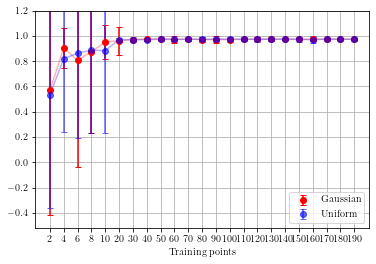

In [53]:
plot_lowpoints(12, 100, S_sizes)

In [16]:
# Load all possible VQEs to compute the transition phase line
N    = 12
side = 100

lr = .25
epochs  = 1000
S_sizes = np.concatenate((np.arange(1,5), np.arange(0,100,5)[1:]))*2

n_qcnns  = 10

In [17]:
path = '../data/vqes/ANNNI/'
filename = 'N'+str(N)+'n'+str(side)

In [18]:
vqeclass = vqe.load_vqe(path+filename)

In [7]:
equi_S = [3,5,7,9]

Cost: 0.001741713611409068: 100%|███████████| 5000/5000 [01:55<00:00, 43.43it/s]
/home/saverio/Desktop/CERN/code/qua/lib/python3.10/site-packages/pennylane/numpy/tensor.py:155: RuntimeWarning: divide by zero encountered in true_divide
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/home/saverio/Desktop/CERN/code/qua/lib/python3.10/site-packages/pennylane/numpy/tensor.py:155: RuntimeWarning: invalid value encountered in multiply
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)


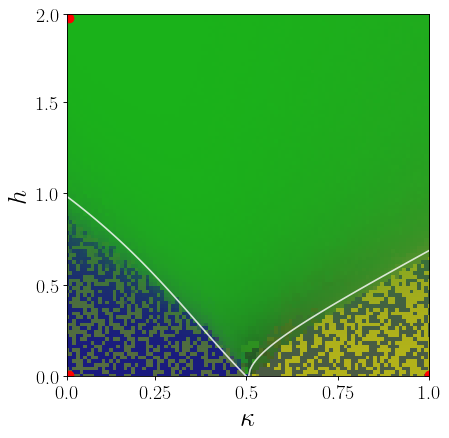

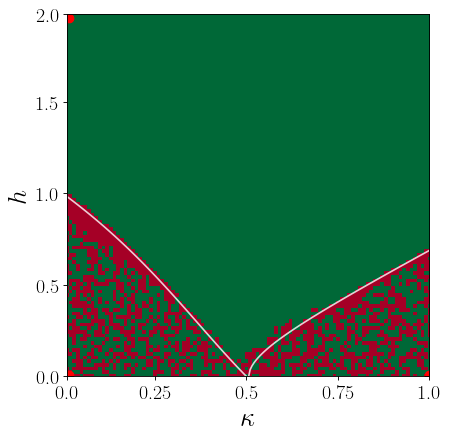

Cost: 0.013360739685595036: 100%|███████████| 5000/5000 [02:18<00:00, 36.10it/s]


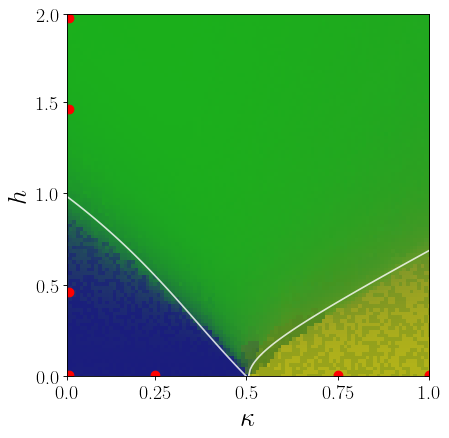

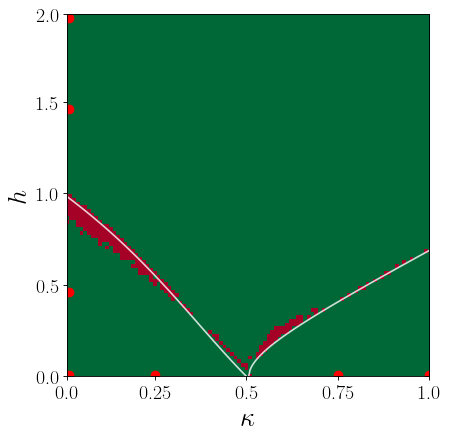

Cost: 0.03715965896844864: 100%|████████████| 5000/5000 [02:39<00:00, 31.40it/s]


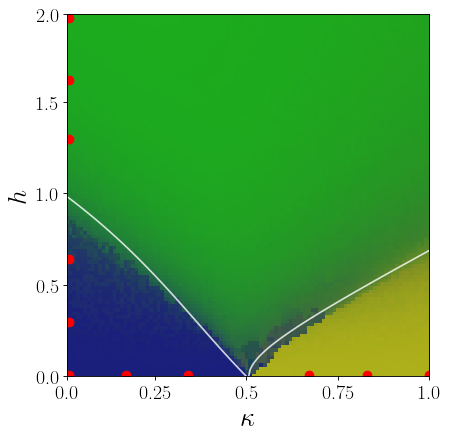

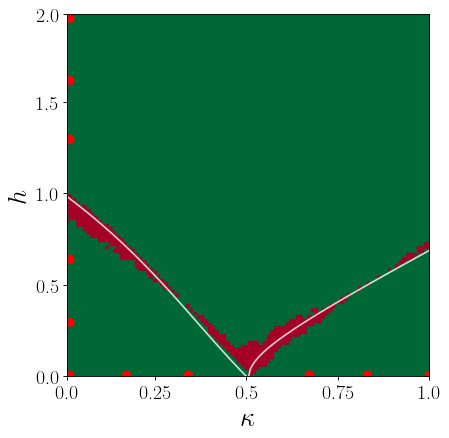

Cost: 0.03643374890089035: 100%|████████████| 5000/5000 [03:02<00:00, 27.37it/s]


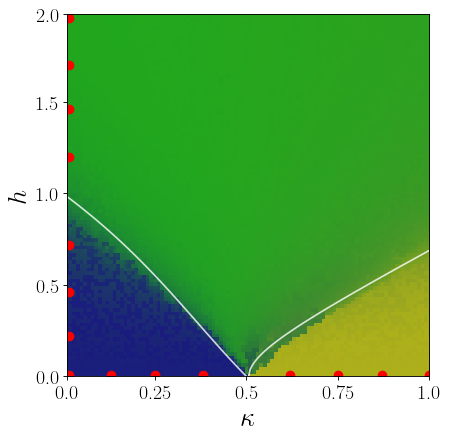

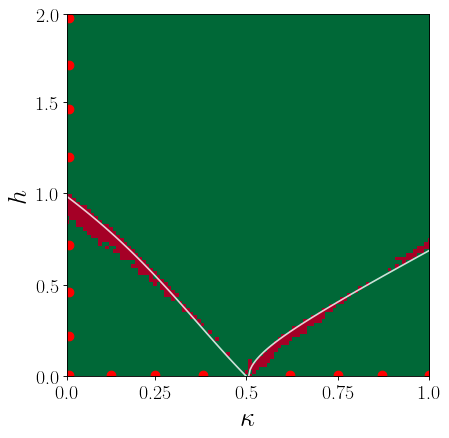

In [8]:
for equi_s in equi_S:
    low_points_equidistant(vqeclass, equi_s, lr, 5*epochs)

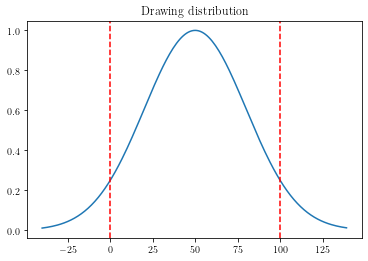

Cost: 0.059540100395679474: 100%|███████████| 1000/1000 [04:57<00:00,  3.36it/s]


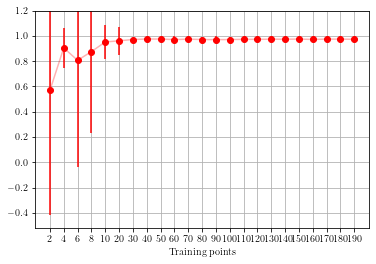

In [19]:
_ = low_points_random(vqeclass, lr, epochs, n_qcnns, S_sizes, sigma = 30, gaussian = True)

Cost: 0.05794978141784668: 100%|████████████| 1000/1000 [04:57<00:00,  3.36it/s]


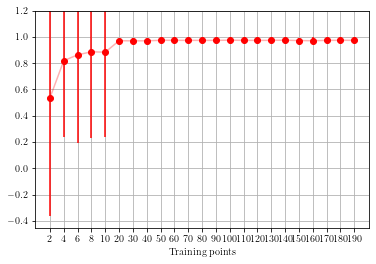

In [20]:
_ = low_points_random(vqeclass, lr, epochs, n_qcnns, S_sizes, sigma = 30, gaussian = False)

In [13]:
del(vqeclass)

In [14]:
myvqe = vqe.load_vqe('../data/vqes/ANNNI/N'+str(N)+'n'+str(side))

# Train VQE recycling parameters 
#myvqe.train(0.3, 250, recycle = True, epochs_batch_size = 250, batch_size = 1)
#myvqe.save('./N'+str(N)+'n'+str(side))
myvqe.train_refine(.2,  1000, 0.002, assist = True)
myvqe.save('./N'+str(N)+'n'+str(side))
myvqe.train_refine(.2,  1000, 0.002, assist = True)
myvqe.save('./N'+str(N)+'n'+str(side))
myvqe.train_refine(.2,  1000, 0.002, assist = True)
myvqe.save('./N'+str(N)+'n'+str(side))
myvqe.train_refine(.1,  1000, 0.002, assist = True)
myvqe.save('./N'+str(N)+'n'+str(side))

  0%|                                                   | 0/100 [10:12<?, ?it/s]


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]